In [1]:
import os
import functools
import numpy as np
import Cell_BLAST as cb
import utils
cb.config.RANDOM_SEED = 0
cb.config.N_JOBS = 4
fixed_model_kwargs = dict(
    latent_dim=10, cat_dim=20,
    epoch=500, patience=20
)

---

# Mouse

### Karaiskos_mouse

/home/weil/software/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


cell_ontology_class  \
GCTATTCTCAAC_1_Podocytes  glomerular visceral epithelial cell   
CCTTATCTTCGC_1_Podocytes  glomerular visceral epithelial cell   
TTGTGAACTAAC_1_Podocytes  glomerular visceral epithelial cell   
ACATCACTCGCA_1_Podocytes  glomerular visceral epithelial cell   
CTGTTGCCTTGT_1_Podocytes  glomerular visceral epithelial cell   

                         cell_ontology_id cell_type1     dataset_name   organ  \
GCTATTCTCAAC_1_Podocytes       CL:0000653  Podocytes  Karaiskos_mouse  Kidney   
CCTTATCTTCGC_1_Podocytes       CL:0000653  Podocytes  Karaiskos_mouse  Kidney   
TTGTGAACTAAC_1_Podocytes       CL:0000653  Podocytes  Karaiskos_mouse  Kidney   
ACATCACTCGCA_1_Podocytes       CL:0000653  Podocytes  Karaiskos_mouse  Kidney   
CTGTTGCCTTGT_1_Podocytes       CL:0000653  Podocytes  Karaiskos_mouse  Kidney   

                              organism  platform     region replicate  
GCTATTCTCAAC_1_Podocytes  Mus musculus  Drop-seq  Glomeruli         1  
CCTTATCTTCGC_1_Podocytes  Mus musculus  Drop-seq  Glomeruli         1  
TTGTGAACTAAC_1_Podocytes  Mus musculus  Drop-seq  Glomeruli         1  
ACATCACTCGCA_1_Podocytes  Mus musculus  Drop-seq  Glomeruli         1  
CTGTTGCCTTGT_1_Podocytes  Mus musculus  Drop-seq  Glomeruli         1

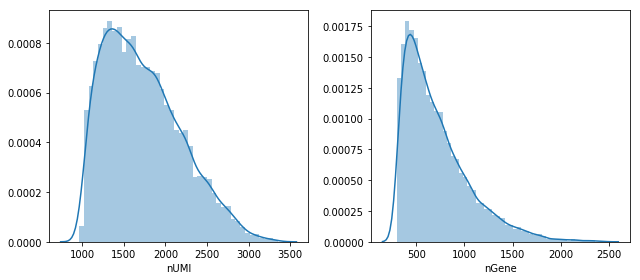

In [2]:
karaiskos_mouse = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Karaiskos_mouse/data.h5")
utils.peek(karaiskos_mouse, "Karaiskos_mouse")
karaiskos_mouse = karaiskos_mouse.normalize()
karaiskos_mouse.obs.head()

In [3]:
opt_model_kwargs = dict(prob_module_kwargs=dict(lambda_reg=0.01))  # We have numerical issue here so `lambda_prob_reg` is used.
karaiskos_mouse_model = cb.directi.fit_DIRECTi(
    karaiskos_mouse, karaiskos_mouse.uns["seurat_genes"],
    **fixed_model_kwargs, **opt_model_kwargs,
    path="/tmp/cb/db/Karaiskos_mouse/model_0"
)
karaiskos_mouse.latent = karaiskos_mouse_model.inference(karaiskos_mouse)

[DIRECTi epoch 0] train=0.865, val=0.861, time elapsed=2.1s Best save...
[DIRECTi epoch 1] train=0.854, val=0.749, time elapsed=1.1s Best save...
[DIRECTi epoch 2] train=0.371, val=0.335, time elapsed=1.1s Best save...
[DIRECTi epoch 3] train=0.282, val=0.289, time elapsed=1.1s Best save...
[DIRECTi epoch 4] train=0.279, val=0.278, time elapsed=1.1s Best save...
[DIRECTi epoch 5] train=0.277, val=0.280, time elapsed=1.1s
[DIRECTi epoch 6] train=0.276, val=0.274, time elapsed=1.1s Best save...
[DIRECTi epoch 7] train=0.272, val=0.268, time elapsed=1.1s Best save...
[DIRECTi epoch 8] train=0.270, val=0.268, time elapsed=1.0s Best save...
[DIRECTi epoch 9] train=0.269, val=0.266, time elapsed=1.0s Best save...
[DIRECTi epoch 10] train=0.267, val=0.262, time elapsed=1.0s Best save...
[DIRECTi epoch 11] train=0.264, val=0.260, time elapsed=1.1s Best save...
[DIRECTi epoch 12] train=0.263, val=0.260, time elapsed=1.0s Best save...
[DIRECTi epoch 13] train=0.262, val=0.260, time elapsed=1.1s 

[  Info   ] Computing tSNE...


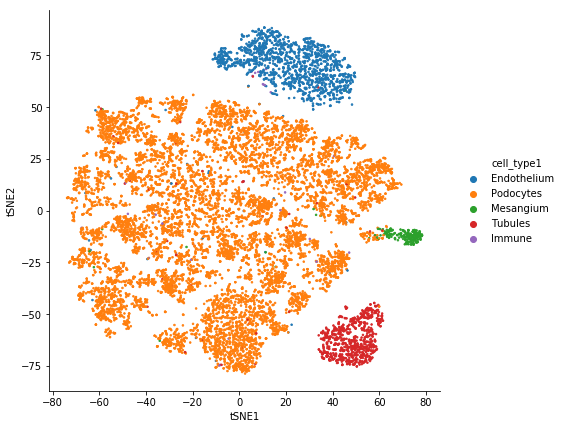

In [4]:
plot = karaiskos_mouse.visualize_latent("cell_type1")
plot.get_figure().savefig("Karaiskos_mouse/cell_type1.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


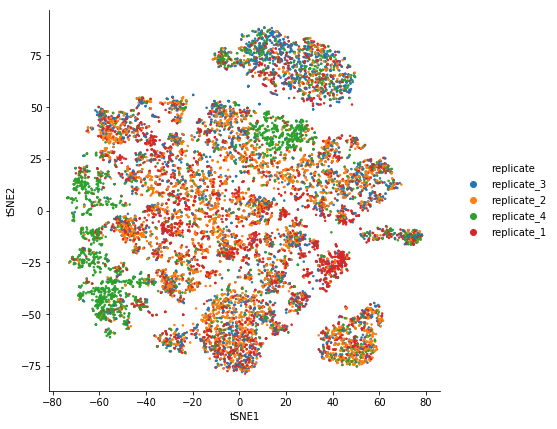

In [5]:
karaiskos_mouse.obs["replicate"] = "replicate_" + karaiskos_mouse.obs["replicate"]
plot = karaiskos_mouse.visualize_latent("replicate")
plot.get_figure().savefig("Karaiskos_mouse/replicate.pdf", bbox_inches="tight")

In [6]:
%%capture capio
karaiskos_mouse_models = [karaiskos_mouse_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    karaiskos_mouse_models.append(cb.directi.fit_DIRECTi(
        karaiskos_mouse, karaiskos_mouse.uns["seurat_genes"],
        **fixed_model_kwargs, **opt_model_kwargs,
        random_seed=i, path="/tmp/cb/db/Karaiskos_mouse/model_%d" % i
    ))
karaiskos_mouse_blast = cb.blast.BLAST(karaiskos_mouse_models, karaiskos_mouse, keep_exprs=True).build_empirical()
karaiskos_mouse_blast.save("Karaiskos_mouse")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/Karaiskos_mouse/model_1/checkpoint-49
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Karaiskos_mouse/model_2/checkpoint-48
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Karaiskos_mouse/model_3/checkpoint-53


In [7]:
with open("Karaiskos_mouse/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("Karaiskos_mouse/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [8]:
utils.self_projection(karaiskos_mouse_blast, "Karaiskos_mouse")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...


/home/weil/software/conda/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Coverage = 0.8721
Accuracy = 0.9935


### Adam

/home/weil/software/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


cell_ontology_class cell_ontology_id cell_type1 dataset_name  \
AATATCGCATTA  mesenchymal stem cell       CL:0000134         CM         Adam   
CTAGCAAGCCCT  mesenchymal stem cell       CL:0000134         CM         Adam   
CGCTCGTGACTA  mesenchymal stem cell       CL:0000134         CM         Adam   
CCATGACGTGGA  mesenchymal stem cell       CL:0000134         CM         Adam   
TTATTAACACCG  mesenchymal stem cell       CL:0000134         CM         Adam   

                     lifestage   organ      organism  platform  
AATATCGCATTA  post natal day 1  Kidney  Mus musculus  Drop-seq  
CTAGCAAGCCCT  post natal day 1  Kidney  Mus musculus  Drop-seq  
CGCTCGTGACTA  post natal day 1  Kidney  Mus musculus  Drop-seq  
CCATGACGTGGA  post natal day 1  Kidney  Mus musculus  Drop-seq  
TTATTAACACCG  post natal day 1  Kidney  Mus musculus  Drop-seq

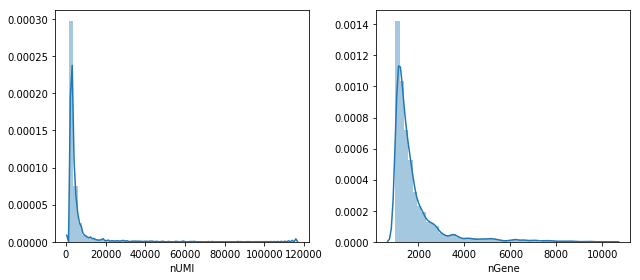

In [9]:
adam = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Adam/data.h5")
utils.peek(adam, "Adam")
adam = adam.normalize()
adam.obs.head()

In [10]:
adam_model = cb.directi.fit_DIRECTi(
    adam, adam.uns["seurat_genes"],
    **fixed_model_kwargs,
    path="/tmp/cb/db/Adam/model_0"
)
adam.latent = adam_model.inference(adam)

[DIRECTi epoch 0] train=2.082, val=2.165, time elapsed=1.2s Best save...
[DIRECTi epoch 1] train=2.071, val=2.151, time elapsed=0.3s Best save...
[DIRECTi epoch 2] train=2.058, val=2.134, time elapsed=0.3s Best save...
[DIRECTi epoch 3] train=2.039, val=2.110, time elapsed=0.3s Best save...
[DIRECTi epoch 4] train=1.998, val=2.017, time elapsed=0.3s Best save...
[DIRECTi epoch 5] train=1.613, val=1.176, time elapsed=0.3s Best save...
[DIRECTi epoch 6] train=0.869, val=0.799, time elapsed=0.3s Best save...
[DIRECTi epoch 7] train=0.733, val=0.756, time elapsed=0.3s Best save...
[DIRECTi epoch 8] train=0.721, val=0.757, time elapsed=0.3s
[DIRECTi epoch 9] train=0.719, val=0.781, time elapsed=0.3s
[DIRECTi epoch 10] train=0.717, val=0.752, time elapsed=0.3s Best save...
[DIRECTi epoch 11] train=0.716, val=0.751, time elapsed=0.3s Best save...
[DIRECTi epoch 12] train=0.715, val=0.742, time elapsed=0.3s Best save...
[DIRECTi epoch 13] train=0.714, val=0.744, time elapsed=0.3s
[DIRECTi epoc

[  Info   ] Computing tSNE...


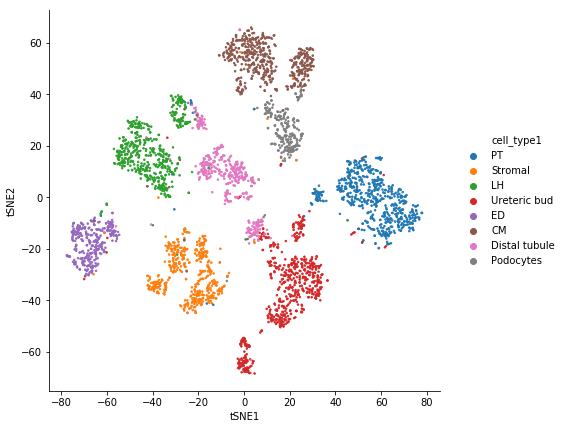

In [11]:
plot = adam.visualize_latent("cell_type1")
plot.get_figure().savefig("Adam/cell_type1.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


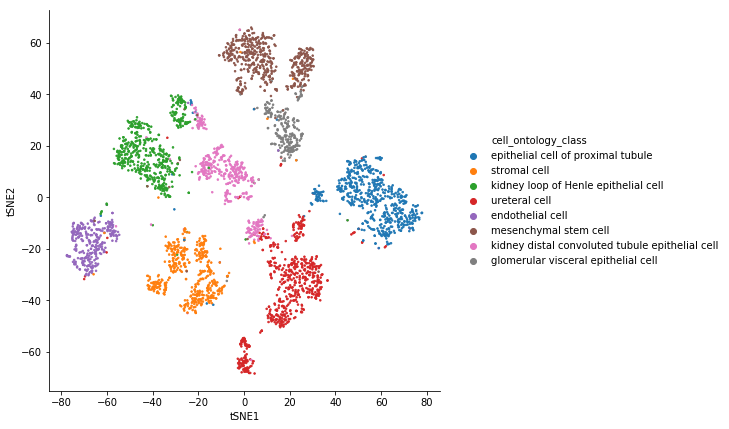

In [12]:
plot = adam.visualize_latent("cell_ontology_class")
plot.get_figure().savefig("Adam/cell_ontology_class.pdf", bbox_inches="tight")

In [13]:
%%capture capio
adam_models = [adam_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    adam_models.append(cb.directi.fit_DIRECTi(
        adam, adam.uns["seurat_genes"],
        **fixed_model_kwargs,
        random_seed=i, path="/tmp/cb/db/Adam/model_%d" % i
    ))
adam_blast = cb.blast.BLAST(adam_models, adam, keep_exprs=True).build_empirical()
adam_blast.save("Adam")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/Adam/model_1/checkpoint-189
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Adam/model_2/checkpoint-126
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Adam/model_3/checkpoint-162


In [14]:
with open("Adam/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("Adam/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [15]:
utils.self_projection(adam_blast, "Adam")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.9844
Accuracy = 0.9806


### Quake_10x_Kidney

cell_ontology_class  \
10X_P4_5_AAACCTGAGATGCCAG                     natural killer cell   
10X_P4_5_AAACCTGAGTGTCCAT       kidney capillary endothelial cell   
10X_P4_5_AAACCTGCAAGGCTCC                          mesangial cell   
10X_P4_5_AAACCTGTCCTTGCCA                             kidney cell   
10X_P4_5_AAACGGGAGCTGAACG  kidney collecting duct epithelial cell   

                          cell_ontology_id  \
10X_P4_5_AAACCTGAGATGCCAG       CL:0000623   
10X_P4_5_AAACCTGAGTGTCCAT       CL:1000892   
10X_P4_5_AAACCTGCAAGGCTCC       CL:0000650   
10X_P4_5_AAACCTGTCCTTGCCA       CL:1000497   
10X_P4_5_AAACGGGAGCTGAACG       CL:1000454   

                                                       cell_type1  cluster  \
10X_P4_5_AAACCTGAGATGCCAG                     natural killer cell     13.0   
10X_P4_5_AAACCTGAGTGTCCAT       kidney capillary endothelial cell      1.0   
10X_P4_5_AAACCTGCAAGGCTCC                          mesangial cell     11.0   
10X_P4_5_AAACCTGTCCTTGCCA                             kidney cell     12.0   
10X_P4_5_AAACGGGAGCTGAACG  kidney collecting duct epithelial cell     10.0   

                               dataset_name  donor free_annotation gender  \
10X_P4_5_AAACCTGAGATGCCAG  Quake_10x_Kidney  3-M-8                      M   
10X_P4_5_AAACCTGAGTGTCCAT  Quake_10x_Kidney  3-M-8                      M   
10X_P4_5_AAACCTGCAAGGCTCC  Quake_10x_Kidney  3-M-8                      M   
10X_P4_5_AAACCTGTCCTTGCCA  Quake_10x_Kidney  3-M-8                      M   
10X_P4_5_AAACGGGAGCTGAACG  Quake_10x_Kidney  3-M-8                      M   

                            organ      organism     plate platform region  
10X_P4_5_AAACCTGAGATGCCAG  Kidney  Mus musculus  10X_P4_5      10x         
10X_P4_5_AAACCTGAGTGTCCAT  Kidney  Mus musculus  10X_P4_5      10x         
10X_P4_5_AAACCTGCAAGGCTCC  Kidney  Mus musculus  10X_P4_5      10x         
10X_P4_5_AAACCTGTCCTTGCCA  Kidney  Mus musculus  10X_P4_5      10x         
10X_P4_5_AAACGGGAGCTGAACG  Kidney  Mus musculus  10X_P4_5      10x

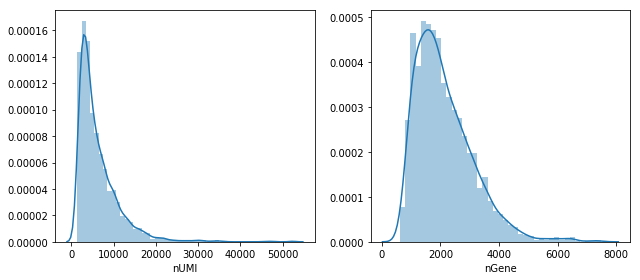

In [16]:
quake_10x_kidney = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Quake_10x_Kidney/data.h5")
utils.peek(quake_10x_kidney, "Quake_10x_Kidney")
quake_10x_kidney = quake_10x_kidney.normalize()
quake_10x_kidney.obs.head()

In [17]:
opt_model_kwargs = dict(batch_effect="donor")
quake_10x_kidney_model = cb.directi.fit_DIRECTi(
    quake_10x_kidney, quake_10x_kidney.uns["seurat_genes"],
    **fixed_model_kwargs, **opt_model_kwargs,
    path="/tmp/cb/db/Quake_10x_Kidney/model_0"
)
quake_10x_kidney.latent = quake_10x_kidney_model.inference(quake_10x_kidney)

[DIRECTi epoch 0] train=2.213, val=2.260, time elapsed=1.2s Regular save...
[DIRECTi epoch 1] train=2.210, val=2.256, time elapsed=0.3s
[DIRECTi epoch 2] train=2.203, val=2.249, time elapsed=0.3s
[DIRECTi epoch 3] train=2.195, val=2.238, time elapsed=0.3s
[DIRECTi epoch 4] train=2.181, val=2.222, time elapsed=0.3s
[DIRECTi epoch 5] train=2.164, val=2.196, time elapsed=0.3s
[DIRECTi epoch 6] train=2.116, val=2.102, time elapsed=0.3s
[DIRECTi epoch 7] train=1.721, val=1.309, time elapsed=0.3s
[DIRECTi epoch 8] train=0.924, val=0.913, time elapsed=0.3s
[DIRECTi epoch 9] train=0.794, val=0.916, time elapsed=0.3s
[DIRECTi epoch 10] train=0.780, val=0.916, time elapsed=0.3s Regular save...
[DIRECTi epoch 11] train=0.778, val=0.912, time elapsed=0.3s
[DIRECTi epoch 12] train=0.774, val=0.867, time elapsed=0.3s
[DIRECTi epoch 13] train=0.774, val=0.865, time elapsed=0.3s
[DIRECTi epoch 14] train=0.773, val=0.855, time elapsed=0.3s
[DIRECTi epoch 15] train=0.768, val=0.805, time elapsed=0.3s
[D

[  Info   ] Computing tSNE...


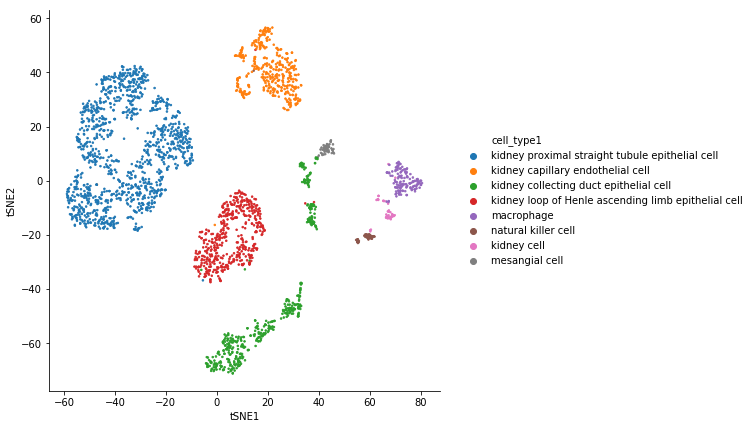

In [18]:
plot = quake_10x_kidney.visualize_latent("cell_type1")
plot.get_figure().savefig("Quake_10x_Kidney/cell_type1.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


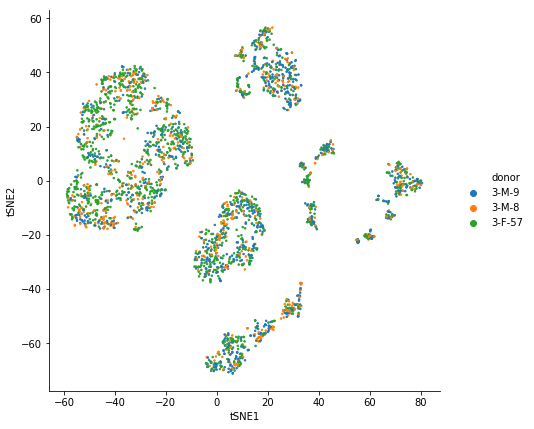

In [19]:
plot = quake_10x_kidney.visualize_latent("donor")
plot.get_figure().savefig("Quake_10x_Kidney/donor.pdf", bbox_inches="tight")

In [20]:
%%capture capio
quake_10x_kidney_models = [quake_10x_kidney_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    quake_10x_kidney_models.append(cb.directi.fit_DIRECTi(
        quake_10x_kidney, quake_10x_kidney.uns["seurat_genes"],
        **fixed_model_kwargs, **opt_model_kwargs,
        random_seed=i, path="/tmp/cb/db/Quake_10x_Kidney/model_%d" % i
    ))
quake_10x_kidney_blast = cb.blast.BLAST(quake_10x_kidney_models, quake_10x_kidney, keep_exprs=True).build_empirical()
quake_10x_kidney_blast.save("Quake_10x_Kidney")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/Quake_10x_Kidney/model_1/checkpoint-196
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Quake_10x_Kidney/model_2/checkpoint-174
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Quake_10x_Kidney/model_3/checkpoint-199


In [21]:
with open("Quake_10x_Kidney/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("Quake_10x_Kidney/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [22]:
utils.self_projection(quake_10x_kidney_blast, "Quake_10x_Kidney")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.9612
Accuracy = 0.9966


## Mouse aligned

In [23]:
if not os.path.exists("ALIGNED_Mus_musculus_Kidney"):
    os.makedirs("ALIGNED_Mus_musculus_Kidney")
quake_10x_kidney.obs["quake_10x_kidney_donor"] = quake_10x_kidney.obs["donor"]
quake_smart_seq2_kidney = cb.data.ExprDataSet.read_dataset(
    "../../Datasets/data/Quake_Smart-seq2_Kidney/data.h5"
).normalize()
mouse = cb.data.ExprDataSet.merge_datasets(dict(
    karaiskos_mouse=karaiskos_mouse, adam=adam,
    quake_smart_seq2_kidney=quake_smart_seq2_kidney,
    quake_10x_kidney=quake_10x_kidney
), merge_uns_slots=["seurat_genes"]).normalize()

[ Warning ] 13516 out of 34872 variables are not found, will be set to zero!
[ Warning ] 11075 out of 34872 variables are not found, will be set to zero!
[ Warning ] 11531 out of 34872 variables are not found, will be set to zero!
[ Warning ] 11531 out of 34872 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...


/home/weil/software/conda/lib/python3.6/site-packages/Cell_BLAST/data.py:579: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  merged_obs = pd.concat(merged_obs)


Subsampling to make cell type distribution comparable.

In [24]:
np.unique(karaiskos_mouse.obs["cell_type1"], return_counts=True)

(array(['Endothelium', 'Immune', 'Mesangium', 'Podocytes', 'Tubules'],
       dtype=object), array([ 1556,    29,   216, 10325,   828]))

In [25]:
np.random.seed(0)
mask_dict = {}
for ct in np.unique(karaiskos_mouse.obs["cell_type1"]):
    mask_dict[ct] = (karaiskos_mouse.obs["cell_type1"] == ct).values
mask_dict["Podocytes"][np.random.choice(
    np.where(mask_dict["Podocytes"])[0],
    size=9000, replace=False
)] = False
mask_dict["Endothelium"][np.random.choice(
    np.where(mask_dict["Endothelium"])[0],
    size=700, replace=False
)] = False
karaiskos_mouse_downsampled = karaiskos_mouse[
    functools.reduce(np.logical_or, mask_dict.values()), :
]

In [26]:
np.unique(karaiskos_mouse_downsampled.obs["cell_type1"], return_counts=True)

(array(['Endothelium', 'Immune', 'Mesangium', 'Podocytes', 'Tubules'],
       dtype=object), array([ 856,   29,  216, 1325,  828]))

In [27]:
mouse_downsampled = cb.data.ExprDataSet.merge_datasets(dict(
    karaiskos_mouse=karaiskos_mouse_downsampled, adam=adam,
    quake_smart_seq2_kidney=quake_smart_seq2_kidney,
    quake_10x_kidney=quake_10x_kidney
), merge_uns_slots=["seurat_genes"]).normalize()

[ Warning ] 13516 out of 34872 variables are not found, will be set to zero!
[ Warning ] 11075 out of 34872 variables are not found, will be set to zero!
[ Warning ] 11531 out of 34872 variables are not found, will be set to zero!
[ Warning ] 11531 out of 34872 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...


In [28]:
opt_model_kwargs = dict(
    batch_effect=["dataset_name", "quake_10x_kidney_donor"],
    rmbatch_module_kwargs=dict(lambda_reg=0.005),
    prob_module_kwargs=dict(lambda_reg=0.01)
)
mouse_model = cb.directi.fit_DIRECTi(
    mouse_downsampled, mouse_downsampled.uns["seurat_genes"],
    **fixed_model_kwargs, **opt_model_kwargs,
    path="/tmp/cb/db/ALIGNED_Mus_musculus_Kidney/model_0"
)
mouse.latent = mouse_model.inference(mouse)

[DIRECTi epoch 0] train=1.441, val=1.462, time elapsed=2.1s Regular save...
[DIRECTi epoch 1] train=1.429, val=1.429, time elapsed=1.2s
[DIRECTi epoch 2] train=0.936, val=0.888, time elapsed=1.2s
[DIRECTi epoch 3] train=0.593, val=0.644, time elapsed=1.2s
[DIRECTi epoch 4] train=0.577, val=0.598, time elapsed=1.2s
[DIRECTi epoch 5] train=0.561, val=0.581, time elapsed=1.2s
[DIRECTi epoch 6] train=0.548, val=0.563, time elapsed=1.2s
[DIRECTi epoch 7] train=0.540, val=0.555, time elapsed=1.2s
[DIRECTi epoch 8] train=0.532, val=0.545, time elapsed=1.2s
[DIRECTi epoch 9] train=0.527, val=0.540, time elapsed=1.2s
[DIRECTi epoch 10] train=0.524, val=0.536, time elapsed=1.2s Regular save...
[DIRECTi epoch 11] train=0.521, val=0.534, time elapsed=1.2s
[DIRECTi epoch 12] train=0.518, val=0.529, time elapsed=1.2s
[DIRECTi epoch 13] train=0.515, val=0.528, time elapsed=1.2s
[DIRECTi epoch 14] train=0.512, val=0.523, time elapsed=1.2s
[DIRECTi epoch 15] train=0.510, val=0.521, time elapsed=1.2s
[D

[  Info   ] Computing tSNE...


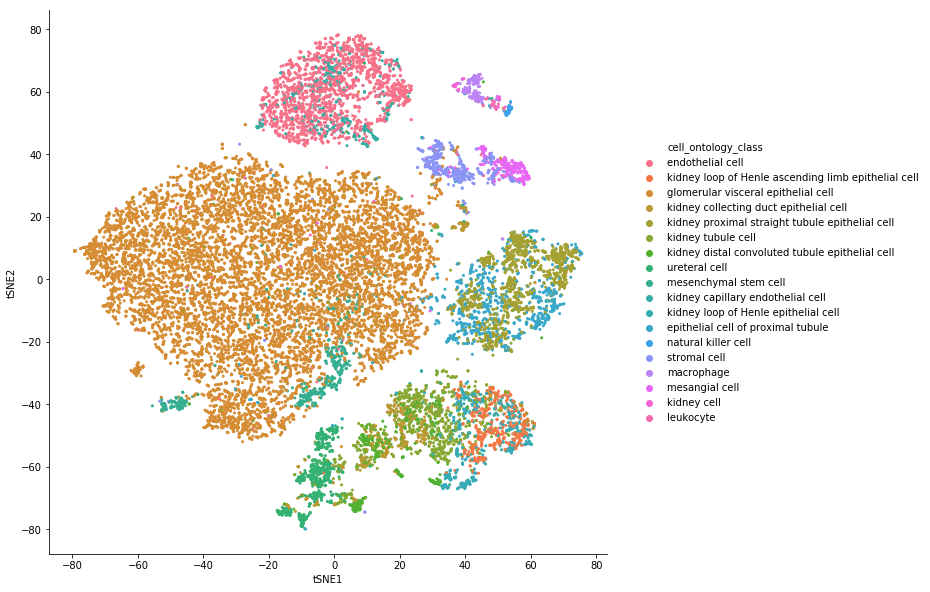

In [29]:
plot = mouse.visualize_latent("cell_ontology_class", width=10, height=10, size=5)
plot.get_figure().savefig("ALIGNED_Mus_musculus_Kidney/cell_ontology_class.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


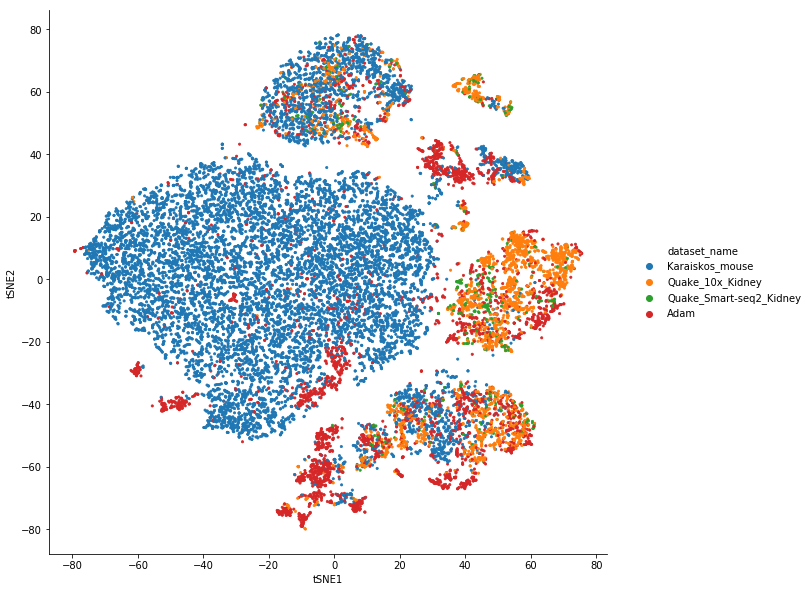

In [30]:
plot = mouse.visualize_latent("dataset_name", width=10, height=10, size=5)
plot.get_figure().savefig("ALIGNED_Mus_musculus_Kidney/study.pdf", bbox_inches="tight")

In [31]:
%%capture capio
mouse_models = [mouse_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    mouse_models.append(cb.directi.fit_DIRECTi(
        mouse, mouse.uns["seurat_genes"],
        **fixed_model_kwargs, **opt_model_kwargs,
        random_seed=i, path="/tmp/cb/db/ALIGNED_Mus_musculus_Kidney/model_%d" % i
    ))
mouse_blast = cb.blast.BLAST(mouse_models, mouse, keep_exprs=True).build_empirical()
mouse_blast.save("ALIGNED_Mus_musculus_Kidney")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/ALIGNED_Mus_musculus_Kidney/model_1/checkpoint-81
INFO:tensorflow:Restoring parameters from /tmp/cb/db/ALIGNED_Mus_musculus_Kidney/model_2/checkpoint-72
INFO:tensorflow:Restoring parameters from /tmp/cb/db/ALIGNED_Mus_musculus_Kidney/model_3/checkpoint-73


In [32]:
with open("ALIGNED_Mus_musculus_Kidney/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("ALIGNED_Mus_musculus_Kidney/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [33]:
utils.self_projection(mouse_blast, "ALIGNED_Mus_musculus_Kidney")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.8061
Accuracy = 0.9046


---

# Human

### Wang_Kidney

age                  cell_ontology_class  \
Central_7w_embryo2_1  7w       extraglomerular mesangial cell   
Central_7w_embryo2_2  7w                mesenchymal stem cell   
Central_7w_embryo2_3  7w                mesenchymal stem cell   
Central_7w_embryo2_4  7w                mesenchymal stem cell   
Central_7w_embryo2_5  7w  glomerular visceral epithelial cell   

                     cell_ontology_id cell_type1 dataset_name      donor  \
Central_7w_embryo2_1       CL:0002173         EM  Wang_kidney  Donor2_7w   
Central_7w_embryo2_2       CL:0000134         CM  Wang_kidney  Donor2_7w   
Central_7w_embryo2_3       CL:0000134         CM  Wang_kidney  Donor2_7w   
Central_7w_embryo2_4       CL:0000134         CM  Wang_kidney  Donor2_7w   
Central_7w_embryo2_5       CL:0000653         PD  Wang_kidney  Donor2_7w   

                     lifestage   organ      organism           platform  
Central_7w_embryo2_1     fetal  Kidney  Homo sapiens  modified STRT-seq  
Central_7w_embryo2_2     fetal  Kidney  Homo sapiens  modified STRT-seq  
Central_7w_embryo2_3     fetal  Kidney  Homo sapiens  modified STRT-seq  
Central_7w_embryo2_4     fetal  Kidney  Homo sapiens  modified STRT-seq  
Central_7w_embryo2_5     fetal  Kidney  Homo sapiens  modified STRT-seq

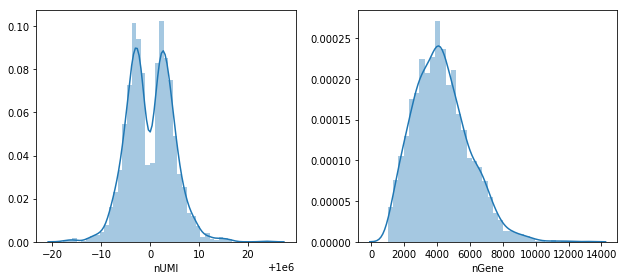

In [34]:
wang_kidney = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Wang_Kidney/data.h5")
utils.peek(wang_kidney, "Wang_Kidney")
wang_kidney = wang_kidney.normalize()
wang_kidney.obs.head()

In [35]:
wang_kidney_model = cb.directi.fit_DIRECTi(
    wang_kidney, wang_kidney.uns["seurat_genes"],
    **fixed_model_kwargs,
    path="/tmp/cb/db/Wang_Kidney/model_0"
)
wang_kidney.latent = wang_kidney_model.inference(wang_kidney)

[DIRECTi epoch 0] train=1.819, val=1.862, time elapsed=1.1s Best save...
[DIRECTi epoch 1] train=1.817, val=1.860, time elapsed=0.2s Best save...
[DIRECTi epoch 2] train=1.813, val=1.854, time elapsed=0.2s Best save...
[DIRECTi epoch 3] train=1.807, val=1.846, time elapsed=0.3s Best save...
[DIRECTi epoch 4] train=1.798, val=1.835, time elapsed=0.2s Best save...
[DIRECTi epoch 5] train=1.784, val=1.819, time elapsed=0.3s Best save...
[DIRECTi epoch 6] train=1.763, val=1.786, time elapsed=0.3s Best save...
[DIRECTi epoch 7] train=1.587, val=1.410, time elapsed=0.3s Best save...
[DIRECTi epoch 8] train=1.104, val=1.034, time elapsed=0.3s Best save...
[DIRECTi epoch 9] train=0.906, val=1.045, time elapsed=0.2s
[DIRECTi epoch 10] train=0.890, val=1.016, time elapsed=0.3s Best save...
[DIRECTi epoch 11] train=0.887, val=1.014, time elapsed=0.2s Best save...
[DIRECTi epoch 12] train=0.887, val=1.131, time elapsed=0.2s
[DIRECTi epoch 13] train=0.884, val=1.295, time elapsed=0.2s
[DIRECTi epoc

[  Info   ] Computing tSNE...


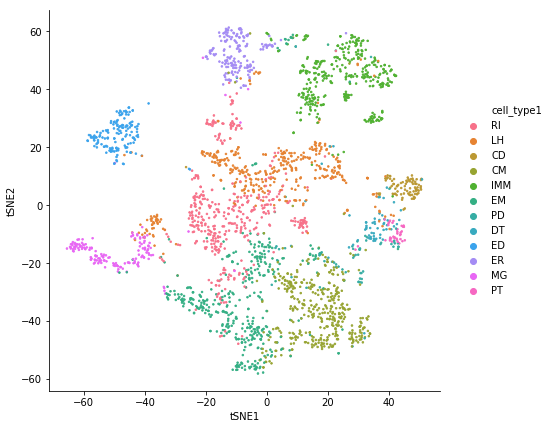

In [36]:
plot = wang_kidney.visualize_latent("cell_type1")
plot.get_figure().savefig("Wang_Kidney/cell_type1.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


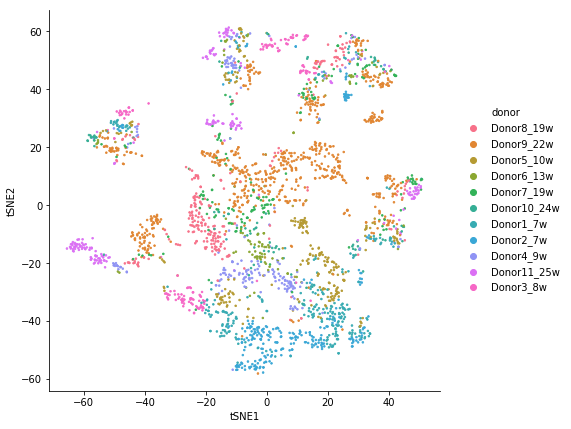

In [37]:
plot = wang_kidney.visualize_latent("donor")
plot.get_figure().savefig("Wang_Kidney/donoe.pdf", bbox_inches="tight")

In [38]:
%%capture capio
wang_kidney_models = [wang_kidney_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    wang_kidney_models.append(cb.directi.fit_DIRECTi(
        wang_kidney, wang_kidney.uns["seurat_genes"],
        **fixed_model_kwargs,
        random_seed=i, path="/tmp/cb/db/Wang_Kidney/model_%d" % i
    ))
wang_kidney_blast = cb.blast.BLAST(wang_kidney_models, wang_kidney, keep_exprs=True).build_empirical()
wang_kidney_blast.save("Wang_Kidney")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/Wang_Kidney/model_1/checkpoint-214
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Wang_Kidney/model_2/checkpoint-176
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Wang_Kidney/model_3/checkpoint-193


In [39]:
with open("Wang_Kidney/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("Wang_Kidney/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [40]:
utils.self_projection(wang_kidney_blast, "Wang_Kidney")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.9226
Accuracy = 0.9369


\>\>\> Discard in alignment

### Wu_human

cell_ontology_class  \
Batch1_AAACCTGGTAAAGGAG  kidney loop of Henle ascending limb epithelial...   
Batch1_AAACGGGCAACGATGG    kidney distal convoluted tubule epithelial cell   
Batch1_AAACGGGCACCCATTC                               renal principal cell   
Batch1_AAACGGGGTCACTGGC    kidney distal convoluted tubule epithelial cell   
Batch1_AAACGGGTCCTTGCCA                      renal alpha-intercalated cell   

                        cell_ontology_id cell_type1 dataset_name   organ  \
Batch1_AAACCTGGTAAAGGAG       CL:1001016   LH(AL#1)     Wu_human  Kidney   
Batch1_AAACGGGCAACGATGG       CL:1000849        DCT     Wu_human  Kidney   
Batch1_AAACGGGCACCCATTC       CL:0005009         PC     Wu_human  Kidney   
Batch1_AAACGGGGTCACTGGC       CL:1000849        DCT     Wu_human  Kidney   
Batch1_AAACGGGTCCTTGCCA       CL:0005011       IC-A     Wu_human  Kidney   

                             organism       platform  
Batch1_AAACCTGGTAAAGGAG  Homo sapiens  10x_snRNA-seq  
Batch1_AAACGGGCAACGATGG  Homo sapiens  10x_snRNA-seq  
Batch1_AAACGGGCACCCATTC  Homo sapiens  10x_snRNA-seq  
Batch1_AAACGGGGTCACTGGC  Homo sapiens  10x_snRNA-seq  
Batch1_AAACGGGTCCTTGCCA  Homo sapiens  10x_snRNA-seq

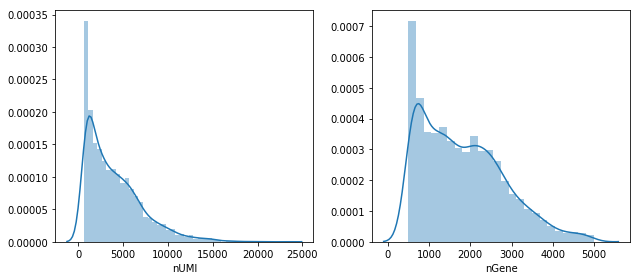

In [41]:
wu_human = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Wu_human/data.h5")
utils.peek(wu_human, "Wu_human")
wu_human = wu_human.normalize()
wu_human.obs.head()

In [42]:
wu_human_model = cb.directi.fit_DIRECTi(
    wu_human, wu_human.uns["seurat_genes"],
    **fixed_model_kwargs,
    path="/tmp/cb/db/Wu_human/model_0"
)
wu_human.latent = wu_human_model.inference(wu_human)

[DIRECTi epoch 0] train=1.985, val=2.000, time elapsed=1.3s Best save...
[DIRECTi epoch 1] train=1.971, val=1.982, time elapsed=0.4s Best save...
[DIRECTi epoch 2] train=1.952, val=1.962, time elapsed=0.4s Best save...
[DIRECTi epoch 3] train=1.918, val=1.891, time elapsed=0.4s Best save...
[DIRECTi epoch 4] train=1.582, val=1.216, time elapsed=0.4s Best save...
[DIRECTi epoch 5] train=0.858, val=0.766, time elapsed=0.4s Best save...
[DIRECTi epoch 6] train=0.723, val=0.890, time elapsed=0.4s
[DIRECTi epoch 7] train=0.715, val=0.814, time elapsed=0.4s
[DIRECTi epoch 8] train=0.713, val=0.805, time elapsed=0.4s
[DIRECTi epoch 9] train=0.712, val=0.768, time elapsed=0.4s
[DIRECTi epoch 10] train=0.711, val=0.771, time elapsed=0.4s
[DIRECTi epoch 11] train=0.709, val=0.772, time elapsed=0.4s
[DIRECTi epoch 12] train=0.698, val=0.726, time elapsed=0.4s Best save...
[DIRECTi epoch 13] train=0.686, val=0.720, time elapsed=0.4s Best save...
[DIRECTi epoch 14] train=0.682, val=0.710, time elap

[  Info   ] Computing tSNE...


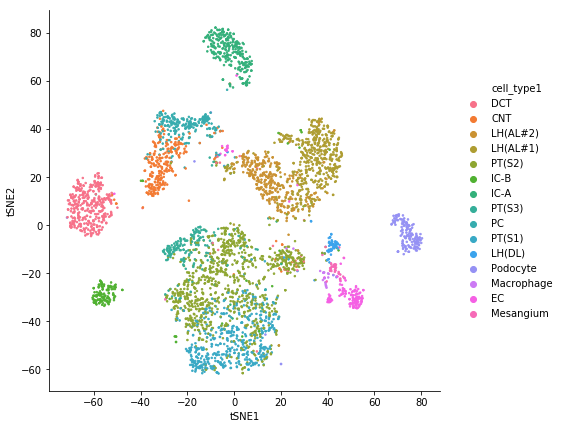

In [43]:
plot = wu_human.visualize_latent("cell_type1")
plot.get_figure().savefig("Wu_human/cell_type1.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


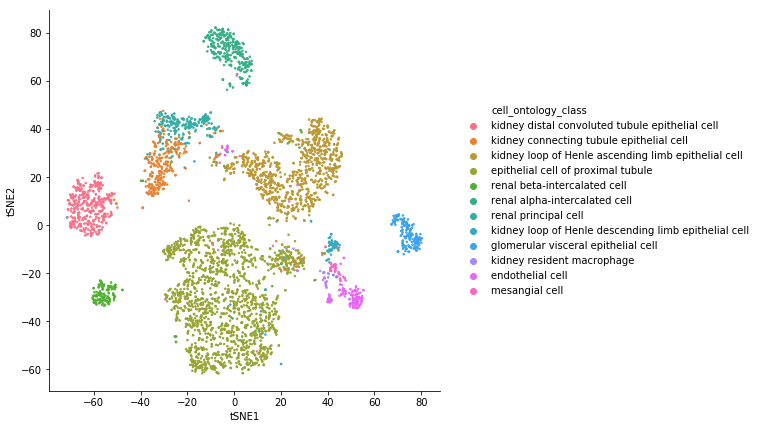

In [44]:
plot = wu_human.visualize_latent("cell_ontology_class")
plot.get_figure().savefig("Wu_human/cell_ontology_class.pdf", bbox_inches="tight")

In [45]:
%%capture capio
wu_human_models = [wu_human_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    wu_human_models.append(cb.directi.fit_DIRECTi(
        wu_human, wu_human.uns["seurat_genes"],
        **fixed_model_kwargs,
        random_seed=i, path="/tmp/cb/db/Wu_human/model_%d" % i
    ))
wu_human_blast = cb.blast.BLAST(wu_human_models, wu_human, keep_exprs=True).build_empirical()
wu_human_blast.save("Wu_human")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/Wu_human/model_1/checkpoint-137
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Wu_human/model_2/checkpoint-103
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Wu_human/model_3/checkpoint-129


In [46]:
with open("Wu_human/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("Wu_human/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [47]:
utils.self_projection(wu_human_blast, "Wu_human")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.8327
Accuracy = 0.9810


### Young

AgeInMonthsPostConception  \
4602STDY6949188___CCGGTAGAGGATGCGT                      153.0   
4602STDY6976428___GGCGACTGTCACTGGC                      765.0   
4602STDY7018923___GCATACACAGTTTACG                       27.0   
4602STDY6949188___GCAGTTAAGAATCTCC                      153.0   
4602STDY6949184___TAGAGCTAGTGTCCAT                      153.0   

                                    BiologicalRepNo ClusterID  TechnicalRepNo  \
4602STDY6949188___CCGGTAGAGGATGCGT              2.0        N0             1.0   
4602STDY6976428___GGCGACTGTCACTGGC              1.0        N0             3.0   
4602STDY7018923___GCATACACAGTTTACG              1.0        N0             1.0   
4602STDY6949188___GCAGTTAAGAATCTCC              2.0        N0             1.0   
4602STDY6949184___TAGAGCTAGTGTCCAT              1.0        N0             1.0   

                                                 age  \
4602STDY6949188___CCGGTAGAGGATGCGT          12 years   
4602STDY6976428___GGCGACTGTCACTGGC                63   
4602STDY7018923___GCATACACAGTTTACG  2 years 6 months   
4602STDY6949188___GCAGTTAAGAATCTCC          12 years   
4602STDY6949184___TAGAGCTAGTGTCCAT          12 years   

                                                     cell_ontology_class  \
4602STDY6949188___CCGGTAGAGGATGCGT  kidney loop of Henle epithelial cell   
4602STDY6976428___GGCGACTGTCACTGGC  kidney loop of Henle epithelial cell   
4602STDY7018923___GCATACACAGTTTACG  kidney loop of Henle epithelial cell   
4602STDY6949188___GCAGTTAAGAATCTCC  kidney loop of Henle epithelial cell   
4602STDY6949184___TAGAGCTAGTGTCCAT  kidney loop of Henle epithelial cell   

                                   cell_ontology_id          cell_type0  \
4602STDY6949188___CCGGTAGAGGATGCGT       CL:1000909  Nephron_epithelium   
4602STDY6976428___GGCGACTGTCACTGGC       CL:1000909  Nephron_epithelium   
4602STDY7018923___GCATACACAGTTTACG       CL:1000909  Nephron_epithelium   
4602STDY6949188___GCAGTTAAGAATCTCC       CL:1000909  Nephron_epithelium   
4602STDY6949184___TAGAGCTAGTGTCCAT       CL:1000909  Nephron_epithelium   

                                       cell_type1 cell_type2 dataset_name  \
4602STDY6949188___CCGGTAGAGGATGCGT  Loop_of_Henle          -        Young   
4602STDY6976428___GGCGACTGTCACTGGC  Loop_of_Henle          -        Young   
4602STDY7018923___GCATACACAGTTTACG  Loop_of_Henle          -        Young   
4602STDY6949188___GCAGTTAAGAATCTCC  Loop_of_Henle          -        Young   
4602STDY6949184___TAGAGCTAGTGTCCAT  Loop_of_Henle          -        Young   

                                         donor   organ      organism platform  \
4602STDY6949188___CCGGTAGAGGATGCGT  Adolescent  Kidney  Homo sapiens      10x   
4602STDY6976428___GGCGACTGTCACTGGC      Adult3  Kidney  Homo sapiens      10x   
4602STDY7018923___GCATACACAGTTTACG      Child3  Kidney  Homo sapiens      10x   
4602STDY6949188___GCAGTTAAGAATCTCC  Adolescent  Kidney  Homo sapiens      10x   
4602STDY6949184___TAGAGCTAGTGTCCAT  Adolescent  Kidney  Homo sapiens      10x   

                                     region  
4602STDY6949188___CCGGTAGAGGATGCGT  Medulla  
4602STDY6976428___GGCGACTGTCACTGGC       NA  
4602STDY7018923___GCATACACAGTTTACG   Cortex  
4602STDY6949188___GCAGTTAAGAATCTCC  Medulla  
4602STDY6949184___TAGAGCTAGTGTCCAT   Cortex

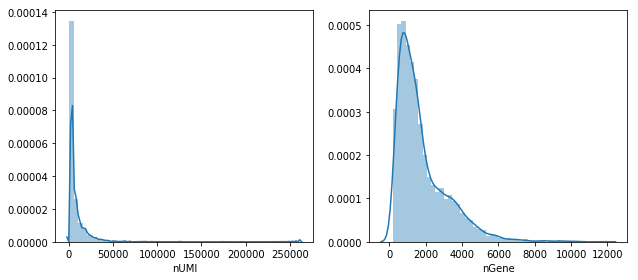

In [48]:
young = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Young/data.h5")
utils.peek(young, "Young")
young = young.normalize()
young.obs.head()

In [49]:
opt_model_kwargs = dict(batch_effect="donor")
young_model = cb.directi.fit_DIRECTi(
    young, young.uns["seurat_genes"],
    **fixed_model_kwargs, **opt_model_kwargs,
    path="/tmp/cb/db/Young/model_0"
)
young.latent = young_model.inference(young)

[DIRECTi epoch 0] train=2.448, val=2.485, time elapsed=1.6s Regular save...
[DIRECTi epoch 1] train=2.437, val=2.465, time elapsed=0.6s
[DIRECTi epoch 2] train=2.406, val=2.409, time elapsed=0.6s
[DIRECTi epoch 3] train=1.899, val=1.296, time elapsed=0.6s
[DIRECTi epoch 4] train=0.956, val=1.350, time elapsed=0.6s
[DIRECTi epoch 5] train=0.930, val=1.086, time elapsed=0.6s
[DIRECTi epoch 6] train=0.926, val=1.011, time elapsed=0.6s
[DIRECTi epoch 7] train=0.910, val=0.972, time elapsed=0.6s
[DIRECTi epoch 8] train=0.881, val=0.922, time elapsed=0.6s
[DIRECTi epoch 9] train=0.870, val=0.927, time elapsed=0.6s
[DIRECTi epoch 10] train=0.865, val=0.905, time elapsed=0.6s Regular save...
[DIRECTi epoch 11] train=0.857, val=0.877, time elapsed=0.6s
[DIRECTi epoch 12] train=0.847, val=0.868, time elapsed=0.6s
[DIRECTi epoch 13] train=0.837, val=0.870, time elapsed=0.6s
[DIRECTi epoch 14] train=0.823, val=0.861, time elapsed=0.5s
[DIRECTi epoch 15] train=0.815, val=0.851, time elapsed=0.6s
[D

[  Info   ] Computing tSNE...


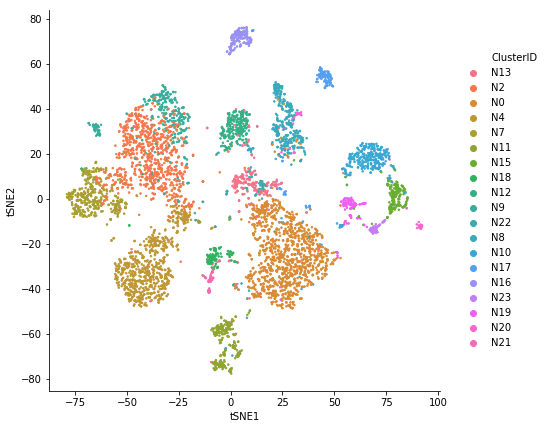

In [50]:
plot = young.visualize_latent("ClusterID")
plot.get_figure().savefig("Young/ClusterID.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


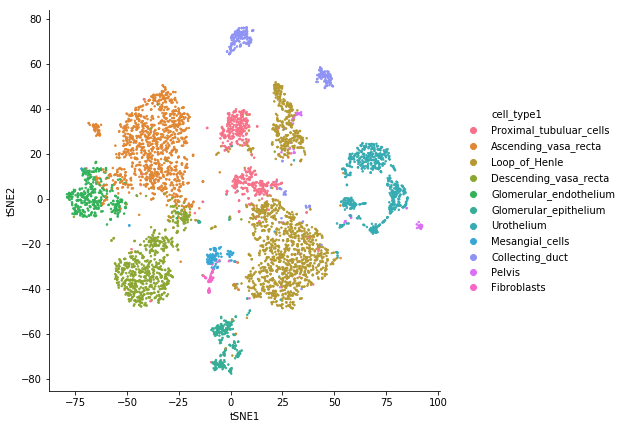

In [51]:
plot = young.visualize_latent("cell_type1")
plot.get_figure().savefig("Young/cell_type1.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


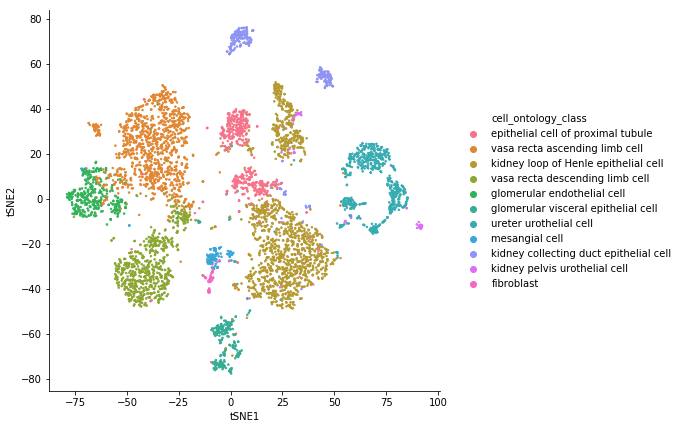

In [52]:
plot = young.visualize_latent("cell_ontology_class")
plot.get_figure().savefig("Young/cell_ontology_class.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


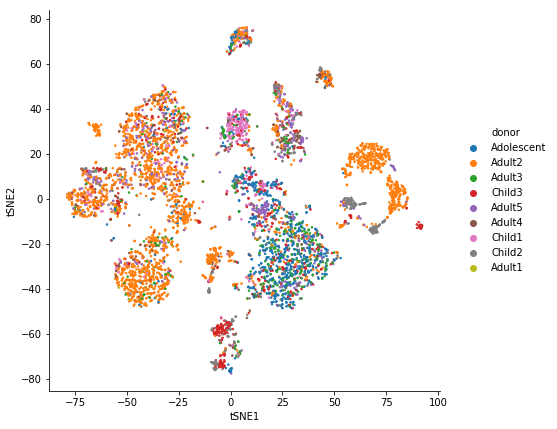

In [53]:
plot = young.visualize_latent("donor")
plot.get_figure().savefig("Young/donor.pdf", bbox_inches="tight")

In [54]:
%%capture capio
young_models = [young_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    young_models.append(cb.directi.fit_DIRECTi(
        young, young.uns["seurat_genes"],
        **fixed_model_kwargs, **opt_model_kwargs,
        random_seed=i, path="/tmp/cb/db/Young/model_%d" % i
    ))
young_blast = cb.blast.BLAST(young_models, young, keep_exprs=True).build_empirical()
young_blast.save("Young")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/Young/model_1/checkpoint-140
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Young/model_2/checkpoint-118
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Young/model_3/checkpoint-93


In [55]:
with open("Young/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("Young/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [56]:
utils.self_projection(young_blast, "Young")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.9033
Accuracy = 0.9766


### Park

annotation  \
AAACCTGAGATATGCA.1      exact   
AAACCTGGTTGTGGCC.1      exact   
AAACGGGAGCGTCTAT.1      exact   
AAACGGGAGCTCCTTC.1      exact   
AAACGGGCACCTCGGA.1      exact   

                                                cell_ontology_class  \
AAACCTGAGATATGCA.1               epithelial cell of proximal tubule   
AAACCTGGTTGTGGCC.1  kidney distal convoluted tubule epithelial cell   
AAACGGGAGCGTCTAT.1               epithelial cell of proximal tubule   
AAACGGGAGCTCCTTC.1               epithelial cell of proximal tubule   
AAACGGGCACCTCGGA.1               epithelial cell of proximal tubule   

                   cell_ontology_id cell_type1 dataset_name    donor  \
AAACCTGAGATATGCA.1       CL:0002306         PT         Park  donor_1   
AAACCTGGTTGTGGCC.1       CL:1000849        DCT         Park  donor_1   
AAACGGGAGCGTCTAT.1       CL:0002306         PT         Park  donor_1   
AAACGGGAGCTCCTTC.1       CL:0002306         PT         Park  donor_1   
AAACGGGCACCTCGGA.1       CL:0002306         PT         Park  donor_1   

                                   full_name   organ      organism platform  
AAACCTGAGATATGCA.1           proximal tubule  Kidney  Mus musculus      10x  
AAACCTGGTTGTGGCC.1  distal convoluted tubule  Kidney  Mus musculus      10x  
AAACGGGAGCGTCTAT.1           proximal tubule  Kidney  Mus musculus      10x  
AAACGGGAGCTCCTTC.1           proximal tubule  Kidney  Mus musculus      10x  
AAACGGGCACCTCGGA.1           proximal tubule  Kidney  Mus musculus      10x

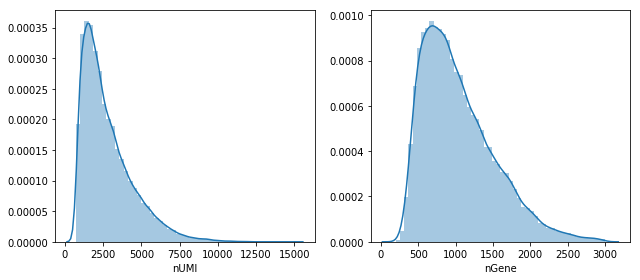

In [57]:
park = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Park/data.h5")
utils.peek(park, "Park")
park = park.normalize()
park.obs.head()

In [58]:
opt_model_kwargs = dict(batch_effect="donor")
park_model = cb.directi.fit_DIRECTi(
    park, park.uns["seurat_genes"],
    **fixed_model_kwargs, **opt_model_kwargs,
    path="/tmp/cb/db/Park/model_0"
)
park.latent = park_model.inference(park)

[DIRECTi epoch 0] train=0.694, val=0.324, time elapsed=5.4s Regular save...
[DIRECTi epoch 1] train=0.302, val=0.292, time elapsed=4.8s
[DIRECTi epoch 2] train=0.285, val=0.279, time elapsed=4.7s
[DIRECTi epoch 3] train=0.276, val=0.273, time elapsed=4.6s
[DIRECTi epoch 4] train=0.270, val=0.268, time elapsed=4.7s
[DIRECTi epoch 5] train=0.267, val=0.265, time elapsed=4.5s
[DIRECTi epoch 6] train=0.265, val=0.263, time elapsed=4.4s
[DIRECTi epoch 7] train=0.263, val=0.262, time elapsed=4.3s
[DIRECTi epoch 8] train=0.262, val=0.261, time elapsed=4.4s
[DIRECTi epoch 9] train=0.261, val=0.260, time elapsed=4.5s
[DIRECTi epoch 10] train=0.260, val=0.260, time elapsed=4.5s Regular save...
[DIRECTi epoch 11] train=0.260, val=0.260, time elapsed=4.8s
[DIRECTi epoch 12] train=0.259, val=0.259, time elapsed=4.8s
[DIRECTi epoch 13] train=0.259, val=0.259, time elapsed=4.7s
[DIRECTi epoch 14] train=0.259, val=0.258, time elapsed=4.7s
[DIRECTi epoch 15] train=0.258, val=0.258, time elapsed=4.4s
[D

[  Info   ] Computing tSNE...


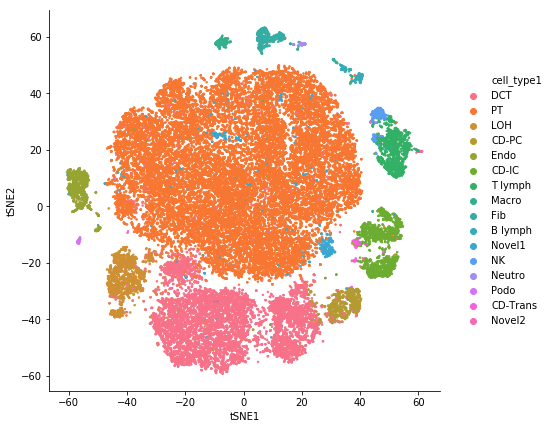

In [59]:
plot = park.visualize_latent("cell_type1")
plot.get_figure().savefig("Park/cell_type1.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


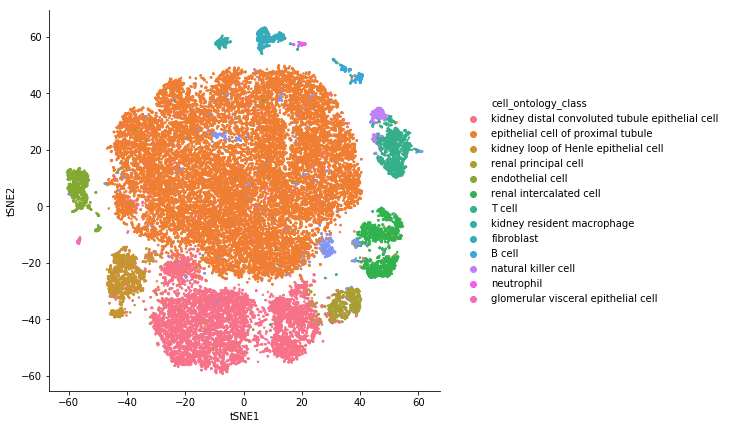

In [60]:
plot = park.visualize_latent("cell_ontology_class")
plot.get_figure().savefig("Park/cell_ontology_class.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


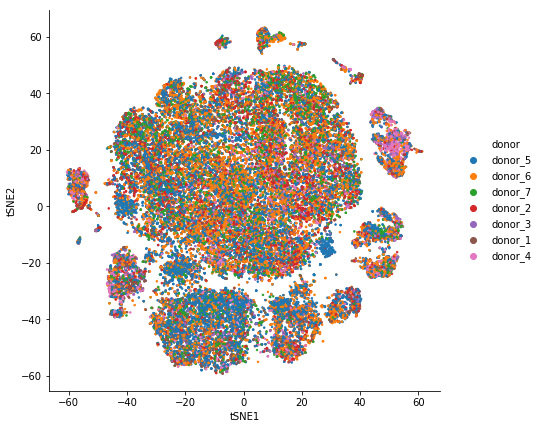

In [61]:
plot = park.visualize_latent("donor")
plot.get_figure().savefig("Park/donor.pdf", bbox_inches="tight")

In [62]:
%%capture capio
park_models = [park_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    park_models.append(cb.directi.fit_DIRECTi(
        park, park.uns["seurat_genes"],
        **fixed_model_kwargs, **opt_model_kwargs,
        random_seed=i, path="/tmp/cb/db/Park/model_%d" % i
    ))
park_blast = cb.blast.BLAST(park_models, park, keep_exprs=True).build_empirical()
park_blast.save("Park")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/Park/model_1/checkpoint-50
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Park/model_2/checkpoint-65
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Park/model_3/checkpoint-68


In [63]:
with open("Park/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("Park/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [64]:
utils.self_projection(park_blast, "Park")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.9461
Accuracy = 0.9816


## Human aligned

In [65]:
if not os.path.exists("ALIGNED_Homo_sapiens_Kidney"):
    os.makedirs("ALIGNED_Homo_sapiens_Kidney")
young.obs["young_donor"] = young.obs["donor"]
human = cb.data.ExprDataSet.merge_datasets(dict(
    wu_human=wu_human, young=young
), merge_uns_slots=["seurat_genes"]).normalize()

[ Warning ] 17369 out of 37825 variables are not found, will be set to zero!
[ Warning ] 4167 out of 37825 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...


In [66]:
opt_model_kwargs = dict(
    batch_effect=["dataset_name", "donor"],
    rmbatch_module=["MNNAdversarial", "Adversarial"],
    rmbatch_module_kwargs=dict(lambda_reg=0.005),
    prob_module_kwargs=dict(lambda_reg=0.01)
)
human_model = cb.directi.fit_DIRECTi(
    human, human.uns["seurat_genes"],
    **fixed_model_kwargs, **opt_model_kwargs,
    path="/tmp/cb/db/ALIGNED_Homo_sapiens_Kidney/model_0"
)
human.latent = human_model.inference(human)

/home/weil/software/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[DIRECTi epoch 0] train=2.077, val=2.075, time elapsed=2.9s Regular save...
[DIRECTi epoch 1] train=2.015, val=1.827, time elapsed=1.3s
[DIRECTi epoch 2] train=1.062, val=1.409, time elapsed=1.4s
[DIRECTi epoch 3] train=0.843, val=1.045, time elapsed=1.4s
[DIRECTi epoch 4] train=0.781, val=0.812, time elapsed=1.3s
[DIRECTi epoch 5] train=0.772, val=0.785, time elapsed=1.4s
[DIRECTi epoch 6] train=0.765, val=0.768, time elapsed=1.4s
[DIRECTi epoch 7] train=0.756, val=0.760, time elapsed=1.4s
[DIRECTi epoch 8] train=0.747, val=0.750, time elapsed=1.4s
[DIRECTi epoch 9] train=0.741, val=0.751, time elapsed=1.4s
[DIRECTi epoch 10] train=0.736, val=0.741, time elapsed=1.4s Regular save...
[DIRECTi epoch 11] train=0.732, val=0.743, time elapsed=1.4s
[DIRECTi epoch 12] train=0.729, val=0.737, time elapsed=1.4s
[DIRECTi epoch 13] train=0.724, val=0.733, time elapsed=1.4s
[DIRECTi epoch 14] train=0.721, val=0.726, time elapsed=1.4s
[DIRECTi epoch 15] train=0.717, val=0.720, time elapsed=1.4s
[D

[  Info   ] Computing tSNE...


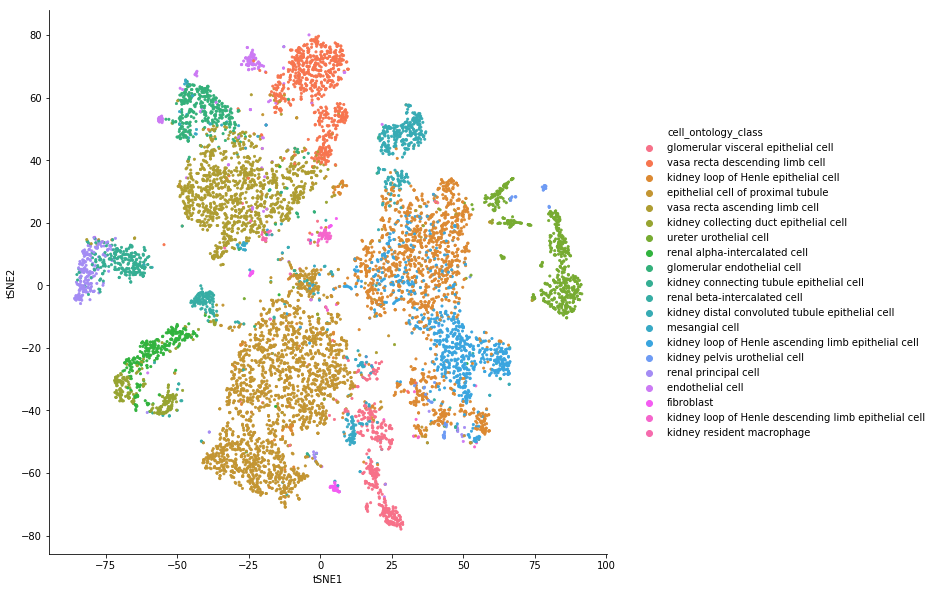

In [67]:
plot = human.visualize_latent("cell_ontology_class", width=10, height=10, size=5)
plot.get_figure().savefig("ALIGNED_Homo_sapiens_Kidney/cell_ontology_class.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


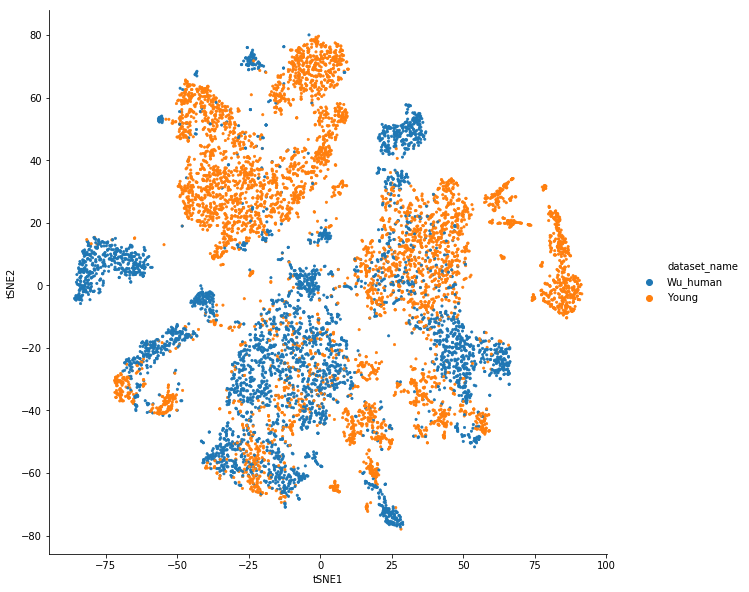

In [68]:
plot = human.visualize_latent("dataset_name", width=10, height=10, size=5)
plot.get_figure().savefig("ALIGNED_Homo_sapiens_Kidney/study.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


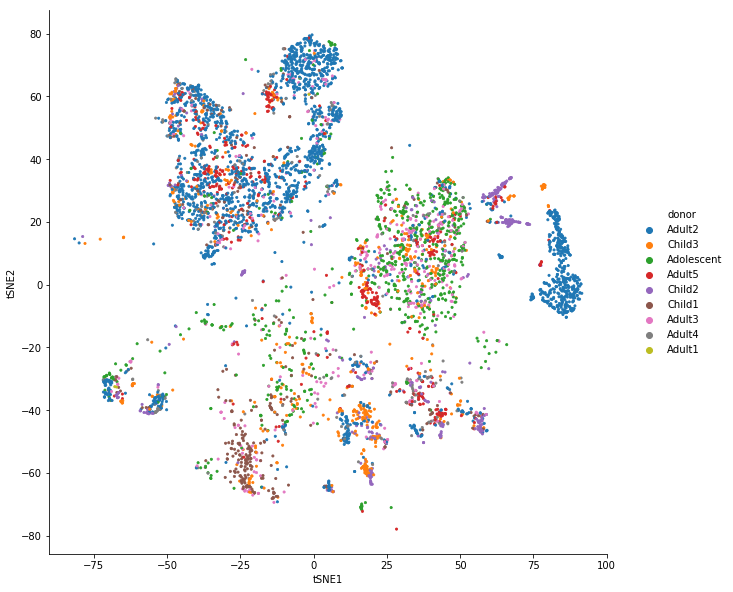

In [69]:
plot = human.visualize_latent("donor", width=10, height=10, size=5)
plot.get_figure().savefig("ALIGNED_Homo_sapiens_Kidney/donor.pdf", bbox_inches="tight")

In [70]:
%%capture capio
human_models = [human_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    human_models.append(cb.directi.fit_DIRECTi(
        human, human.uns["seurat_genes"],
        **fixed_model_kwargs, **opt_model_kwargs,
        random_seed=i, path="/tmp/cb/db/ALIGNED_Homo_sapiens_Kidney/model_%d" % i
    ))
human_blast = cb.blast.BLAST(human_models, human, keep_exprs=True).build_empirical()
human_blast.save("ALIGNED_Homo_sapiens_Kidney")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/ALIGNED_Homo_sapiens_Kidney/model_1/checkpoint-115
INFO:tensorflow:Restoring parameters from /tmp/cb/db/ALIGNED_Homo_sapiens_Kidney/model_2/checkpoint-105
INFO:tensorflow:Restoring parameters from /tmp/cb/db/ALIGNED_Homo_sapiens_Kidney/model_3/checkpoint-97


In [71]:
with open("ALIGNED_Homo_sapiens_Kidney/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("ALIGNED_Homo_sapiens_Kidney/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [72]:
utils.self_projection(human_blast, "ALIGNED_Homo_sapiens_Kidney")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.8184
Accuracy = 0.9436


### Alemany_Kidney

ClusterID cell_ontology_class cell_ontology_id   cell_type1  \
1-p01-wkm-R2        1.0          lymphocyte       CL:0000542  Lymphocytes   
2-p01-wkm-R2        2.0          neutrophil       CL:0000775  Neutrophils   
3-p01-wkm-R2        1.0          lymphocyte       CL:0000542  Lymphocytes   
5-p01-wkm-R2        3.0            monocyte       CL:0000576    Monocytes   
6-p01-wkm-R2        1.0          lymphocyte       CL:0000542  Lymphocytes   

                dataset_name donor lifestage   organ     organism plate  \
1-p01-wkm-R2  Alemany_Kidney    R2     adult  Kidney  Danio rerio   p01   
2-p01-wkm-R2  Alemany_Kidney    R2     adult  Kidney  Danio rerio   p01   
3-p01-wkm-R2  Alemany_Kidney    R2     adult  Kidney  Danio rerio   p01   
5-p01-wkm-R2  Alemany_Kidney    R2     adult  Kidney  Danio rerio   p01   
6-p01-wkm-R2  Alemany_Kidney    R2     adult  Kidney  Danio rerio   p01   

               platform  region  
1-p01-wkm-R2  ScarTrace  marrow  
2-p01-wkm-R2  ScarTrace  marrow  
3-p01-wkm-R2  ScarTrace  marrow  
5-p01-wkm-R2  ScarTrace  marrow  
6-p01-wkm-R2  ScarTrace  marrow

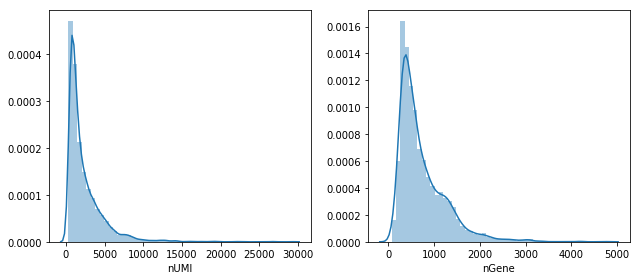

In [73]:
alemany_kidney = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Alemany_Kidney/data.h5")
utils.peek(alemany_kidney, "Alemany_Kidney")
alemany_kidney = alemany_kidney.normalize()
alemany_kidney.obs.head()

In [74]:
opt_model_kwargs = dict(batch_effect="donor")
alemany_kidney_model = cb.directi.fit_DIRECTi(
    alemany_kidney, alemany_kidney.uns["seurat_genes"],
    **fixed_model_kwargs, **opt_model_kwargs,
    path="/tmp/cb/db/Alemany_Kidney/model_0"
)
alemany_kidney.latent = alemany_kidney_model.inference(alemany_kidney)

[DIRECTi epoch 0] train=3.097, val=3.138, time elapsed=1.2s Regular save...
[DIRECTi epoch 1] train=3.083, val=3.115, time elapsed=0.4s
[DIRECTi epoch 2] train=3.052, val=3.072, time elapsed=0.4s
[DIRECTi epoch 3] train=2.975, val=2.891, time elapsed=0.4s
[DIRECTi epoch 4] train=1.759, val=0.931, time elapsed=0.4s
[DIRECTi epoch 5] train=0.714, val=0.747, time elapsed=0.4s
[DIRECTi epoch 6] train=0.678, val=0.784, time elapsed=0.4s
[DIRECTi epoch 7] train=0.675, val=0.691, time elapsed=0.4s
[DIRECTi epoch 8] train=0.673, val=0.666, time elapsed=0.4s
[DIRECTi epoch 9] train=0.666, val=0.663, time elapsed=0.4s
[DIRECTi epoch 10] train=0.642, val=0.835, time elapsed=0.4s Regular save...
[DIRECTi epoch 11] train=0.630, val=0.668, time elapsed=0.4s
[DIRECTi epoch 12] train=0.625, val=0.619, time elapsed=0.4s
[DIRECTi epoch 13] train=0.620, val=0.628, time elapsed=0.4s
[DIRECTi epoch 14] train=0.617, val=0.604, time elapsed=0.4s
[DIRECTi epoch 15] train=0.615, val=0.598, time elapsed=0.4s
[D

[  Info   ] Computing tSNE...


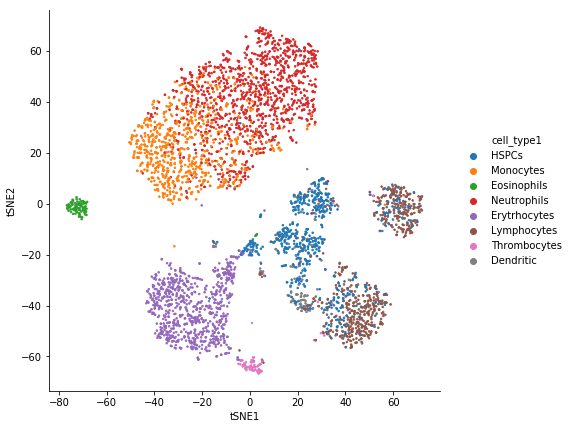

In [75]:
plot = alemany_kidney.visualize_latent("cell_type1")
plot.get_figure().savefig("Alemany_Kidney/cell_type1.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


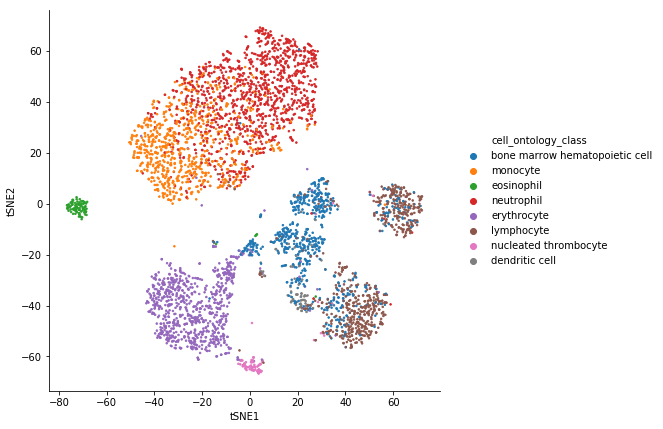

In [76]:
plot = alemany_kidney.visualize_latent("cell_ontology_class")
plot.get_figure().savefig("Alemany_Kidney/cell_ontology_class.pdf", bbox_inches="tight")

[  Info   ] Using cached tSNE...


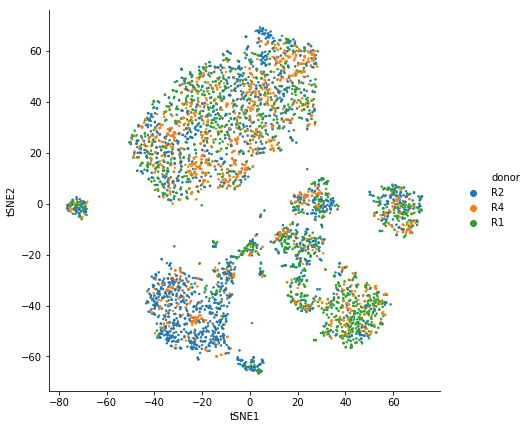

In [77]:
plot = alemany_kidney.visualize_latent("donor")
plot.get_figure().savefig("Alemany_Kidney/donor.pdf", bbox_inches="tight")

In [78]:
%%capture capio
alemany_kidney_models = [alemany_kidney_model]
for i in range(1, cb.config.N_JOBS):
    print("==== Model %d ====" % i)
    alemany_kidney_models.append(cb.directi.fit_DIRECTi(
        alemany_kidney, alemany_kidney.uns["seurat_genes"],
        **fixed_model_kwargs, **opt_model_kwargs,
        random_seed=i, path="/tmp/cb/db/Alemany_Kidney/model_%d" % i
    ))
alemany_kidney_blast = cb.blast.BLAST(alemany_kidney_models, alemany_kidney, keep_exprs=True).build_empirical()
alemany_kidney_blast.save("Alemany_Kidney")

INFO:tensorflow:Restoring parameters from /tmp/cb/db/Alemany_Kidney/model_1/checkpoint-110
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Alemany_Kidney/model_2/checkpoint-97
INFO:tensorflow:Restoring parameters from /tmp/cb/db/Alemany_Kidney/model_3/checkpoint-102


In [79]:
with open("Alemany_Kidney/stdout.txt", "w") as f:
    f.write(capio.stdout)
with open("Alemany_Kidney/stderr.txt", "w") as f:
    f.write(capio.stderr)

In [80]:
utils.self_projection(alemany_kidney_blast, "Alemany_Kidney")

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
Coverage = 0.7773
Accuracy = 0.8864
